### 필요 라이브러리 호출

In [1]:
# 라이브러리 호출
import re
import os
import unicodedata

import pandas as pd
import numpy as np

import nltk
from nltk import word_tokenize
from nltk.corpus import words

import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional

import torch

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification

from googletrans import Translator

import hanspell
from hanspell import spell_checker
from hanspell.constants import CheckResult

from konlpy.tag import Okt
from konlpy.tag import Komoran

import hgtk
from hangul_utils import join_jamos
from jamo import jamo_to_hangul

import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization, LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

from wordcloud import WordCloud
import seaborn as sns

### 데이터 호출 및 샘플링

In [11]:
# github 댓글 데이터셋을 불러옴
comments_df = pd.read_csv('../data/github_kohate_data.csv')
print(comments_df.columns) # 컬럼 확인
comments_df.shape # 크기 확인

Index(['comments', 'contain_gender_bias', 'bias', 'hate'], dtype='object')


(7896, 4)

In [8]:
# 악성 댓글, 편향 댓글, 정상 댓글들을 숫자로 라벨링하여 새 컬럼 label에 저장
# 라벨 정보 : 0(정상), 1(악성/부정), 2(성/정치 편향)
def new_label(x):
    hate = x['hate']
    bias = x['bias']
    if hate == 'none' and bias == 'none':
        return 0
    elif hate != 'none' and bias == 'none':
        return 1
    elif hate == 'none' and bias != 'none' :
        return 2

# 각 행에 대해서 라벨링 함수를 적용
comments_df['label'] = comments_df.apply(lambda x: new_label(x), axis=1)

# 각 라벨링 개수 출력
print("none_hate_vias_comments :", len(comments_df[comments_df['label'] == 0])) # 정상 댓글
print("only_hate_comments :", len(comments_df[comments_df['label'] == 1])) # 악성/부정 댓글
print("only_vias_comments :", len(comments_df[comments_df['label'] == 2])) # 성/정치 편향 댓글

none_hate_vias_comments : 3273
only_hate_comments : 1875
only_vias_comments : 213


In [4]:
# 편향 댓글의 데이터가 부족하여 악성/부정 + 성/정치 댓글을 큰 범위의 악성댓글로 합쳐서 진행
comments_df['label'] = comments_df['label'].replace(2, 1)

# 각 라벨링 개수 출력
print("== before sampling ==")
print("none_hate_vias_comments :", len(comments_df[comments_df['label'] == 0])) # 정상 댓글
print("hate_vias_comments :", len(comments_df[comments_df['label'] == 1])) # 악성/부정/편향 댓글

# 데이터 불균형 해소를 위해 2,088개씩 랜덤 샘플링
none_hate_comments_df = comments_df[comments_df['label'] == 0].sample(2088, random_state=123)
hate_vias_comments_df = comments_df[comments_df['label'] == 1].sample(2088, random_state=123)

balanced_comments_df = pd.concat([none_hate_comments_df, hate_vias_comments_df])
balanced_comments_df = balanced_comments_df.reset_index(drop=True)

# 각 라벨링 개수 출력
print("\n== after sampling ==")
print("none_hate_vias_comments :", len(balanced_comments_df[balanced_comments_df['label'] == 0])) # 정상 댓글
print("hate_vias_comments :", len(balanced_comments_df[balanced_comments_df['label'] == 1])) # 악성/부정/편향 댓글

== before sampling ==
none_hate_vias_comments : 3273
hate_vias_comments : 2088

== after sampling ==
none_hate_vias_comments : 2088
hate_vias_comments : 2088


### 전처리 및 숫자형 변수 추출

In [ ]:
# qwerty 자판 배열 딕셔너리
qwerty_to_hangul = {
    'r': 'ㄱ', 's': 'ㄴ', 'e': 'ㄷ', 'f': 'ㄹ', 'a': 'ㅁ',
    'q': 'ㅂ', 't': 'ㅅ', 'd': 'ㅇ', 'w': 'ㅈ', 'c': 'ㅊ',
    'z': 'ㅋ', 'x': 'ㅌ', 'v': 'ㅍ', 'g': 'ㅎ',
    'k': 'ㅏ', 'o': 'ㅐ', 'i': 'ㅑ', 'j': 'ㅓ', 'p': 'ㅔ',
    'u': 'ㅕ', 'h': 'ㅗ', 'y': 'ㅛ', 'n': 'ㅜ', 'b': 'ㅠ',
    'm': 'ㅡ', 'l': 'ㅣ', 'Q': 'ㅃ', 'W': 'ㅉ', 'E': 'ㄸ',
    'R': 'ㄲ', 'T': 'ㅆ', 'O': 'ㅒ', 'P': 'ㅖ',
}

def eng_to_kr(word): # 영어 -> 한글로 변환
    change_result = ""
    for ch in word: # 한 글자씩 찾아서 매핑핑
        change_result += qwerty_to_hangul.get(ch, ch)  # 매핑 안되면 원래 글자 사용
    return join_jamos(change_result)

# 특성 추출 및 전처리
# han-spell의 경우 처리할 때마다 시간이 많이 소요되기 때문에 자원 낭비를 방지하고자 특성 추출과 전처리를 동시에 진행
def extract_features_and_preprocessing(x):
    clean_comment = re.sub(r'\s+', ' ', x).strip() # 공백 제거

    comment_len = len(clean_comment) # 문장 전체 길이
    
    english_word = re.sub(r'[^a-zA-Z]', '', clean_comment) # 영어 단어만 추출
    english_word_count = len(english_word) / comment_len # 영어 단어 비율

    special_word = re.sub(r'[ㄱ-ㅣ가-힣a-zA-Z0-9\s]', '', clean_comment) # 특수 문자 + 이모지만 남김
    special_word_count = len(special_word) / comment_len # 특수 문자 + 이모지 비율
    clean_comment = re.sub(r'[^ㄱ-ㅣ가-힣a-zA-Z0-9\s]', '', clean_comment) # 특수 문자 + 이모지 제거
    
    initial_consonants = re.sub(r'[ㄱ-ㅎㅏ-ㅣ]', '', clean_comment) # 초성만 남김
    initial_consonants_count = len(initial_consonants) / comment_len # 초성 비율
    clean_comment = re.sub(r'([ㄱ-ㅎㅏ-ㅣ])\1{2,}\s*', '', clean_comment) # 3회 이상 반복되는 초성 제거(ex. ㅋㅋㅋ, ㅎㅎㅎ)
    
    okt_morpheme_list = okt.pos(clean_comment) # okt로 형태소 분석
    for morpheme in okt_morpheme_list: 
        origin_word = morpheme[0] # 기존 형태를 저장
        if morpheme[1] == "KoreanParticle": # 초성과 중성인 경우를 찾음
            join_word = join_jamos(origin_word) # 초성과 중성을 원래대로 합침
            clean_comment = clean_comment.replace(origin_word, join_word) # 합쳐진 단어로 바꿔서 저장
        elif morpheme[1] == "Alpha" and len(morpheme[0]) >= 2:
            change_word = eng_to_kr(origin_word) # 영어로 작성된 것을 한글로 변환
            clean_comment = clean_comment.replace(origin_word, change_word) # 한글로 변환된 단어로 바꿔서 저장

    spell_check_result = spell_checker.check(clean_comment) # 맞춤법 검사 결과를 저장
    spell_error_count = spell_check_result.errors # 틀린 맞춤법, 띄어쓰기기 개수
    clean_comment = spell_check_result.checked # 맞춤법, 띄어쓰기 보정 된 텍스트

    komoran_morpheme_list = komoran.pos(clean_comment) # komoran으로 형태소 분석
    np_count = 0 # 대명사 빈도 변수
    for morpheme in komoran_morpheme_list:
        if morpheme[1] == "NP": # 대명사를 찾아서 빈도를 증가
            np_count = np_count + 1
            
    clean_comment = unicodedata.normalize('NFKC', clean_comment) # NFKC로 정규화
    
    return pd.Series({ # dataframe에 추가
        'clean_comment': clean_comment,
        'comment_len': comment_len,
        'english_word_count': english_word_count,
        'special_word_count': special_word_count,
        'initial_consonanats_count': initial_consonants_count,
        'spell_error_count': spell_error_count,
        'np_count': np_count
    })
        
okt = Okt()
komoran = Komoran()
features_clean_df = balanced_comments_df['comments'].apply(lambda x: extract_features_and_preprocessing(x))

In [6]:
features_clean_df.head() # 전처리 된 텍스트와 특성 확인

,clean_comment,comment_len,english_word_count,special_word_count,initial_consonanats_count,spell_error_count,np_count
0,살이 너무 쪘다,8,0.0,0.000000,1.000000,0,0
1,역시 방탄이다 제2의 엑소라 불려도 손색이 없네 이제는 ᄒᄃᄃ 흥해라 방탄 응원한다,48,0.0,0.041667,0.895833,1,0
2,하하 플러스 유재석 너무 질린다 ᅳᅳ,20,0.0,0.000000,0.900000,1,0
3,기안84 좋아요,8,0.0,0.000000,1.000000,0,0
4,이세은 너무 비호감이다 ᅲᅲ 다들 공감하실 듯,24,0.0,0.000000,0.916667,2,0


In [7]:
balanced_clean_df = pd.concat([balanced_comments_df, features_clean_df], axis=1) # 하나의 데이터프레임 연결
balanced_clean_df.head()

,comments,contain_gender_bias,bias,hate,label,clean_comment,comment_len,english_word_count,special_word_count,initial_consonanats_count,spell_error_count,np_count
0,살이 너무 쪘다,False,none,none,0.0,살이 너무 쪘다,8,0.0,0.000000,1.000000,0,0
1,역시 방탄이다 제2의 엑소라 불려도 손색이 없네 이제는 ㅎㄷㄷ 흥해라 방탄 응원한다!!,False,none,none,0.0,역시 방탄이다 제2의 엑소라 불려도 손색이 없네 이제는 ᄒᄃᄃ 흥해라 방탄 응원한다,48,0.0,0.041667,0.895833,1,0
2,하하 플러스 유재석 너무 질린다 ㅡㅡ,False,none,none,0.0,하하 플러스 유재석 너무 질린다 ᅳᅳ,20,0.0,0.000000,0.900000,1,0
3,기안84 좋아요,False,none,none,0.0,기안84 좋아요,8,0.0,0.000000,1.000000,0,0
4,이세은 너무 비호감이다 ㅠㅠ 다들 공감하실듯,False,none,none,0.0,이세은 너무 비호감이다 ᅲᅲ 다들 공감하실 듯,24,0.0,0.000000,0.916667,2,0


In [8]:
features = [
    'comment_len',
    'special_word_count',
    'initial_consonanats_count',
    'spell_error_count',
    'english_word_count',
    'np_count'
]

for feature in features:
    print(f"\n=== {feature} 평균 비교 ===")
    print(f"정상 댓글 : {balanced_clean_df[balanced_clean_df['label'] == 0][feature].mean()}")
    print(f"악성 댓글 : {balanced_clean_df[balanced_clean_df['label'] == 1][feature].mean()}")


=== comment_len 평균 비교 ===
정상 댓글 : 34.2294061302682
악성 댓글 : 36.95402298850575

=== special_word_count 평균 비교 ===
정상 댓글 : 0.06672769136421539
악성 댓글 : 0.05990334033227233

=== initial_consonanats_count 평균 비교 ===
정상 댓글 : 0.9125080306414953
악성 댓글 : 0.9147660381742911

=== spell_error_count 평균 비교 ===
정상 댓글 : 2.039272030651341
악성 댓글 : 2.4133141762452106

=== english_word_count 평균 비교 ===
정상 댓글 : 0.0022987248684437404
악성 댓글 : 0.0032649502463183554

=== np_count 평균 비교 ===
정상 댓글 : 0.2260536398467433
악성 댓글 : 0.3472222222222222


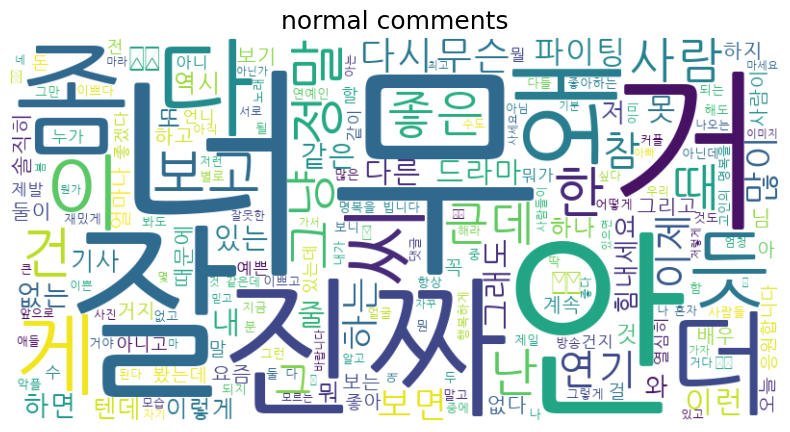

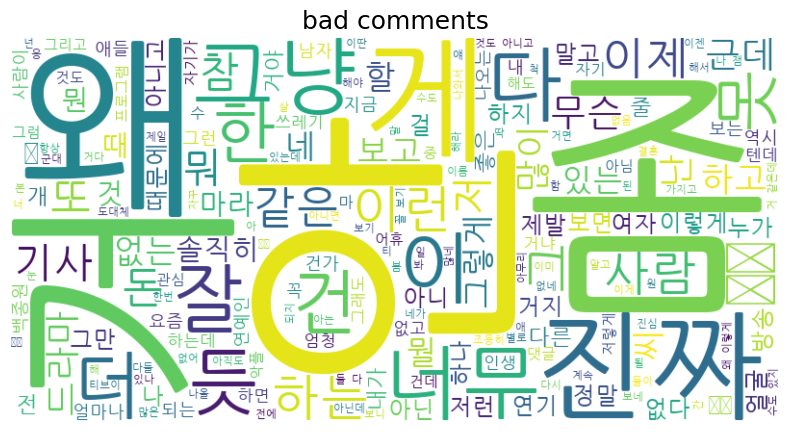

In [ ]:
norm_comment = " ".join(balanced_clean_df[balanced_clean_df['label'] == 0]['clean_comment'].astype(str))
bad_comment = " ".join(balanced_clean_df[balanced_clean_df['label'] == 1]['clean_comment'].astype(str))

def plot_wordcloud(text, title):
    font_path = '../font/NanumGothic.ttf'
    wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18)
    plt.show()

plot_wordcloud(norm_comment, 'normal comments')
plot_wordcloud(bad_comment, 'bad comments')

In [ ]:
selected_columns = ['comment_len', 'english_word_count', 'special_word_count', 'spell_error_count', 'np_count'] # 특성 변수 선택
selected_features_df = balanced_clean_df[selected_columns] # 선택된 특성만 따로 분리

scaler = StandardScaler() # StandardScaler 방식으로 표준화
selected_features_scaled = scaler.fit_transform(selected_features_df) # 선택된 수치형 특성들을 정규화하여 numpy 배열로 저장

### 임베딩

In [11]:
kobert_tokenizer = AutoTokenizer.from_pretrained("monologg/kobert", trust_remote_code=True) # huggingface에서 kobert tokenizer 모델을 가져옴
kobert_model = AutoModel.from_pretrained("monologg/kobert", trust_remote_code=True) # huggingface에서 사전 학습된 kobert 모델을 가져옴
kobert_model.eval() # 모델의 상태를 추론용으로 변경

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(8002, 768, padding_idx=1)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)

In [12]:
def extract_cls_embedding(comment_list, max_len, batch_size): # [CLS] 토큰의 벡터만 추출
    cls_embeddings = []

    with torch.no_grad(): # torch에서 학습을 사용하지 않음
        for i in tqdm(range(0, len(comment_list), batch_size)):
            batch_comment = comment_list[i:i+batch_size] # 한 번에 batch_size만큼 수행할 문장의 개수
            inputs = kobert_tokenizer(batch_comment, truncation=True, padding='max_length', max_length=max_len, return_tensors='pt') # 최대 길이를 넘으면 제거하고, python torch에 저장
            outputs = kobert_model(**inputs)
            cls_vector = outputs.last_hidden_state[:,0,:] # [CLS] 벡터 추출
            cls_embeddings.append(cls_vector.numpy()) # numpy로 변환해서 리스트에 저장

    return np.vstack(cls_embeddings) # 배열을 수직으로 결합해서 하나의 numpy 배열로 만들어서 반환

# 리스트 형식으로 변환하고, 문자 최대 길이, 배치 수를 바탕으로 임베딩함
# 머신러닝 모델에서 사용하기 위해 [CLS] 벡터만 추출
cls_embedding_np = extract_cls_embedding(balanced_clean_df['clean_comment'].tolist(), 128, 32)
cls_embedding_np.shape

100%|██████████| 131/131 [03:45<00:00,  1.72s/it]


(4176, 768)

In [13]:
def extract_embedding(comment_list, max_len, batch_size): # 시퀀스 벡터 추출
    embeddings = []

    with torch.no_grad(): 
        for i in tqdm(range(0, len(comment_list), batch_size)):
            batch_comment = comment_list[i:i+batch_size] 
            inputs = kobert_tokenizer(batch_comment, truncation=True, padding='max_length', max_length=max_len, return_tensors='pt')
            outputs = kobert_model(**inputs)
            line_vector = outputs.last_hidden_state # 모든 토큰에 대한 임베딩 벡터 시퀀스를 가져옴
            embeddings.append(line_vector.numpy()) # numpy로 변환해서 리스트에 저장

    return np.vstack(embeddings)

# LSTM의 경우 시퀀스가 필요하기 때문에 문장 전체의 시퀀스 벡터를 추출
seq_embedding_np = extract_embedding(balanced_clean_df['clean_comment'].tolist(), 128, 32)
seq_embedding_np.shape

100%|██████████| 131/131 [03:43<00:00,  1.71s/it]


(4176, 128, 768)

### 학습/테스트 데이터 준비

In [ ]:
cls_embedding_scaled = scaler.fit_transform(cls_embedding_np) # [CLS] 벡터를 정규화하여 numpy 배열로 저장
combined_cls_embedding = np.concatenate([cls_embedding_scaled, selected_features_scaled], axis=1) # [CLS] 벡터 + 수치형 변수

selected_features_expanded = selected_features_scaled[:, np.newaxis, :] # 시퀀스 벡터의 경우 3차원이기에 차원을 하나 늘려줌
seq_selected_features = np.repeat(selected_features_expanded, 128, axis=1) # 반복해서 시퀀스 길이를 128로 통일일
combined_seq_embedding = np.concatenate([seq_embedding_np, seq_selected_features], axis=2) # 시퀀스 벡터 + 수치형 변수

# 각각의 임베딩 정보들을 80% 학습용 / 20% 검증용으로 데이터 분할
y = balanced_clean_df['label'].values # label 정보
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(combined_cls_embedding, y, test_size=0.2, random_state=42)
X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(combined_seq_embedding, y, test_size=0.2, random_state=42)

### 머신러닝 모델 정의 및 학습 후 평가

--- LogisticRegression ---
Accuracy: 0.6004784688995215
Precision: 0.5676959619952494
Recall: 0.6112531969309463
F1 Score: 0.5886699507389163
--- RandomForest ---
Accuracy: 0.5801435406698564
Precision: 0.5462962962962963
Recall: 0.6035805626598465
F1 Score: 0.5735115431348724
--- XGBoost ---
Accuracy: 0.6052631578947368
Precision: 0.5745721271393643
Recall: 0.6010230179028133
F1 Score: 0.5875


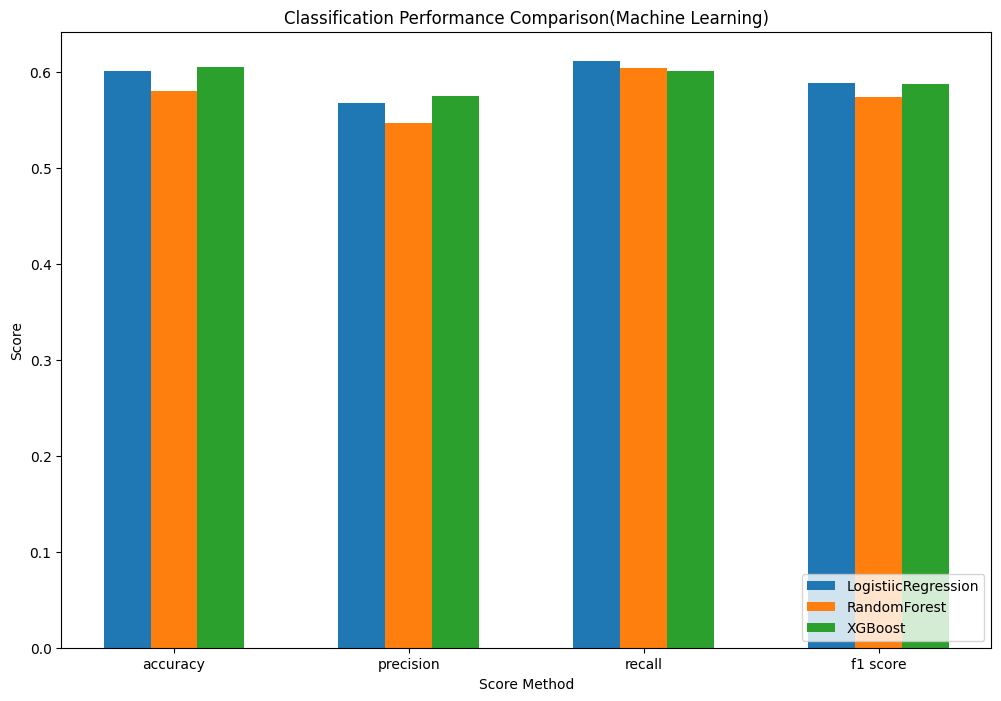

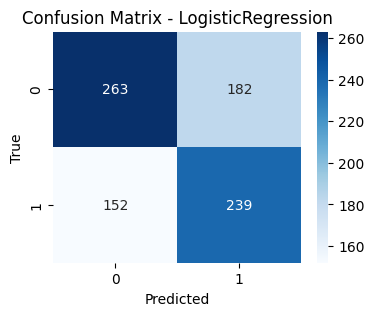

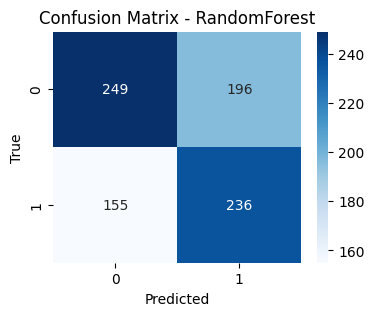

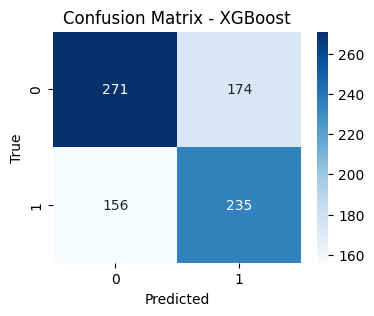

In [47]:
# 머신러닝 모델 학습 및 평가가
machine_learning_models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

machine_learning_model_results = {}

for model_name, model_class in machine_learning_models.items():
    model_class.fit(X_cls_train, y_cls_train)
    y_cls_pred = model_class.predict(X_cls_test)
    
    accuracy = accuracy_score(y_cls_test, y_cls_pred)
    precision = precision_score(y_cls_test, y_cls_pred)
    recall = recall_score(y_cls_test, y_cls_pred)
    f1 = f1_score(y_cls_test, y_cls_pred)
 
    print("--- " + model_name + " ---")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
 
    machine_learning_model_results[model_name] = [accuracy, precision, recall, f1]

score_method = ['accuracy', 'precision', 'recall', 'f1 score']

x = np.arange(len(score_method))

plt.figure(figsize=(12, 8))
plt.bar(x, machine_learning_model_results['LogisticRegression'], width=0.2, label='LogistiicRegression')
plt.bar(x + 0.2, machine_learning_model_results['RandomForest'], width=0.2, label='RandomForest')
plt.bar(x + 0.4, machine_learning_model_results['XGBoost'], width=0.2, label='XGBoost')

plt.xticks(x + 0.2, score_method)

plt.legend(loc='lower right')
plt.title('Classification Performance Comparison(Machine Learning)')
plt.xlabel('Score Method')
plt.ylabel('Score')

plt.show()

for model_name, model_class in machine_learning_models.items():
    y_cls_pred = model_class.predict(X_cls_test)
    cm = confusion_matrix(y_cls_test, y_cls_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

### 모델 정의

In [51]:
def LSTM_Classifier(sequence_length, dimension, learning_rate, dropout_rate): # LSTM 기반 이진 분류 모델
    lstm_input = Input(shape=(sequence_length, dimension), name='Comments_Kobert_Input')
    
    # 첫 번째 BiLSTM (시퀀스 전체 출력)
    x = Bidirectional(LSTM(128, return_sequences=True))(lstm_input)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # 두 번째 BiLSTM (문장 요약)
    x = Bidirectional(LSTM(64))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Dense 층 추가
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    
    # 출력층
    output = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=lstm_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    return model

lstm_model = LSTM_Classifier(128, 773, 0.0001, 0.4)
lstm_model.summary()

lstm_model.fit(
    x=X_seq_train,            
    y=y_seq_train,             
    epochs=10,              
    batch_size=64,          
    validation_split=0.125     
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Comments_Kobert_Input (Inpu  [(None, 128, 773)]       0         
 tLayer)                                                         
                                                                 
 bidirectional_8 (Bidirectio  (None, 128, 256)         923648    
 nal)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 128, 256)         1024      
 hNormalization)                                                 
                                                                 
 dropout_21 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              164352    
 nal)                                                      

In [54]:
def CNN_LSTM_Classifier(sequence_length, dimension, learning_rate, dropout_rate):
    # 입력 레이어
    cnn_input = Input(shape=(sequence_length, dimension), name='Comments_Kobert_Input') # Kobert 임베딩 입력
    
    # 1D Convolution (로컬 패턴 추출)
    x = Conv1D(filters=128, kernel_size=3, activation='relu')(cnn_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    
    # 첫 번째 Bidirectional LSTM
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)

    # 두 번째 Bidirectional LSTM (마지막 타임스텝만 출력)
    x = Bidirectional(LSTM(64))(x)
    x = Dropout(dropout_rate)(x)

    # 완전 연결층(Dense)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    # 출력층 (이진 분류)
    output = Dense(1, activation='sigmoid', name='output')(x)

    # 모델 정의
    model = Model(inputs=cnn_input, outputs=output)

    # 컴파일
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    return model


cnn_lstm_model = CNN_LSTM_Classifier(128, 773, 0.0001, 0.4)
cnn_lstm_model.summary()

cnn_lstm_model.fit(
    x=X_seq_train,           
    y=y_seq_train,         
    epochs=10,
    batch_size=64,
    validation_split=0.125
)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Comments_Kobert_Input (Inpu  [(None, 128, 773)]       0         
 tLayer)                                                         
                                                                 
 conv1d (Conv1D)             (None, 126, 128)          296960    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 128)          0         
 )                                                               
                                                                 
 dropout_28 (Dropout)        (None, 63, 128)           0         
                                                                 
 batch_normalization_10 (Bat  (None, 63, 128)          512       
 chNormalization)                                                
                                                           

In [55]:
def Dense_Classifier(embedding_dim, learning_rate, dropout_rate):
    input_layer = Input(shape=(embedding_dim,), name='KoBERT_Embedding_Input')
    x = Dense(128, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

dense_model = Dense_Classifier(embedding_dim=773, learning_rate=0.0005, dropout_rate=0.4)
dense_model.summary()

dense_model.fit(
    x=X_cls_train,  
    y=y_cls_train,   
    epochs=10,
    batch_size=64,
    validation_split=0.2
)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 KoBERT_Embedding_Input (Inp  [(None, 773)]            0         
 utLayer)                                                        
                                                                 
 dense_20 (Dense)            (None, 128)               99072     
                                                                 
 dropout_32 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                           

### 모델 평가

27/27 [==============================] - 14s 501ms/step


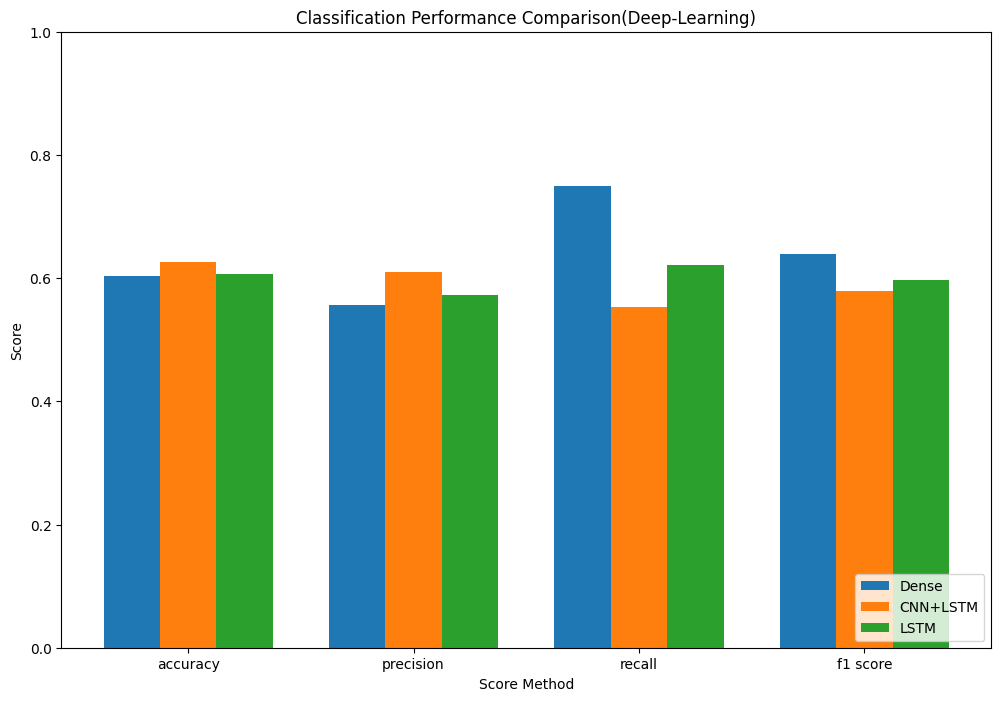

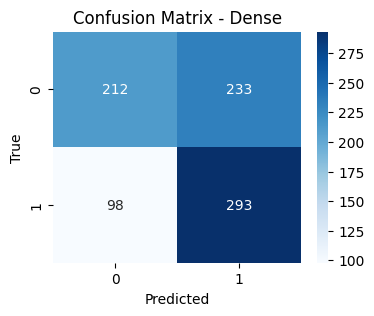

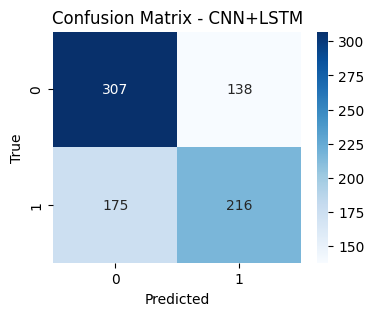

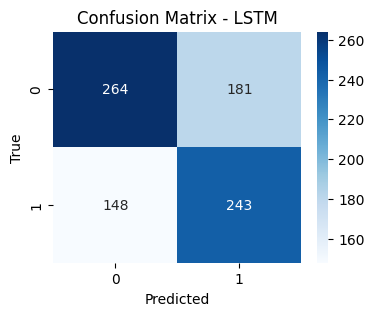

In [56]:
deep_learning_models = {
    'Dense': dense_model,
    'CNN+LSTM': cnn_lstm_model,
    'LSTM': lstm_model
}

deep_learning_model_results = {}
confusion_matrix_results = {}

for name, model in deep_learning_models.items():
    if name == 'Dense': # Dense 모델에는 2차원 데이터 사용
        y_pred_prob = model.predict(X_cls_test)
    else: # LSTM/CNN+LSTM에는 3차원 데이터 사용
        y_pred_prob = model.predict(X_seq_test)
        
    y_pred = (y_pred_prob > 0.5).astype(int).flatten() # 1차원 배열로 변환
    
    if name == 'Dense': # Dense 모델에는 2차원 데이터 사용
        acc = accuracy_score(y_cls_test, y_pred)
        prec = precision_score(y_cls_test, y_pred)
        rec = recall_score(y_cls_test, y_pred)
        f1 = f1_score(y_cls_test, y_pred)
        cm = confusion_matrix(y_cls_test, y_pred)
    else: # LSTM/CNN+LSTM에는 3차원 데이터 사용
        acc = accuracy_score(y_seq_test, y_pred)
        prec = precision_score(y_seq_test, y_pred)
        rec = recall_score(y_seq_test, y_pred)
        f1 = f1_score(y_seq_test, y_pred)
        cm = confusion_matrix(y_seq_test, y_pred)

    deep_learning_model_results[name] = [acc, prec, rec, f1]
    confusion_matrix_results[name] = cm

score_method = ['accuracy', 'precision', 'recall', 'f1 score']
x = np.arange(len(score_method))
bar_width = 0.25

plt.figure(figsize=(12, 8))

plt.bar(x, deep_learning_model_results['Dense'], width=bar_width, label='Dense')
plt.bar(x + bar_width, deep_learning_model_results['CNN+LSTM'], width=bar_width, label='CNN+LSTM')
plt.bar(x + bar_width*2, deep_learning_model_results['LSTM'], width=bar_width, label='LSTM')

plt.xticks(x + bar_width, score_method)
plt.legend(loc='lower right')
plt.title('Classification Performance Comparison(Deep-Learning)')
plt.xlabel('Score Method')
plt.ylabel('Score')

plt.ylim(0, 1)
plt.show()

for name, cm in confusion_matrix_results.items():
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [57]:
print("=== 모델별 평균 점수 ===")
for model, scores in machine_learning_model_results.items():
    avg_score = sum(scores) / 4
    print(f"{model}: {avg_score:.2f}")
for model, scores in deep_learning_model_results.items():
    avg_score = sum(scores) / 4
    print(f"{model}: {avg_score:.2f}")

=== 모델별 평균 점수 ===
LogisticRegression: 0.59
RandomForest: 0.58
XGBoost: 0.59
Dense: 0.64
CNN+LSTM: 0.59
LSTM: 0.60


### 유튜브 댓글로 테스트

In [ ]:
# 유튜브 댓글 데이터을 불러옴
youtube_comment_df = pd.read_csv('../data/youtube_comment.csv', on_bad_lines='skip')
youtube_comment_df.shape

(5905, 11)

In [63]:
youtube_comment_df['comments'] = youtube_comment_df.iloc[:,1].apply(
    lambda x: re.sub(r'.*"text"\s*:\s*"([^"]*)".*', r'\1', str(x)) # text 열을 comments로 저장
)
youtube_comment_df['comments'].head()

0                                    '제 얼굴에 침 뱉기' 교육영상
1     짬뽕밥에 면넣으면 국물 맛이 달라진다고 ??....도무지 이해가 안간다 ㅋㅋㅋㅋㅋㅋㅋㅋ
2    이미지라는 게 참 웃긴게... 예전엔 무슨 말을 해도 정색해도 다 웃기고 사람답다 ...
3                                   완전 대장 노릇에 중독이 됐구만.
4                                                  여보쇼
Name: comments, dtype: object

In [73]:
def extract_features(x):
    clean_comment = re.sub(r'\s+', ' ', x).strip() # 공백 제거

    comment_len = len(clean_comment) # 문장 전체 길이
    
    english_word = re.sub(r'[^a-zA-Z]', '', clean_comment) # 영어 단어만 추출
    english_word_count = len(english_word) / comment_len # 영어 단어 비율

    special_word = re.sub(r'[ㄱ-ㅣ가-힣a-zA-Z0-9\s]', '', clean_comment) # 특수 문자 + 이모지만 남김
    special_word_count = len(special_word) / comment_len # 특수 문자 + 이모지 비율
    clean_comment = re.sub(r'[^ㄱ-ㅣ가-힣a-zA-Z0-9\s]', '', clean_comment) # 특수 문자 + 이모지 제거
    
    initial_consonants = re.sub(r'[ㄱ-ㅎㅏ-ㅣ]', '', clean_comment) # 초성만 남김
    initial_consonants_count = len(initial_consonants) / comment_len # 초성 비율
    clean_comment = re.sub(r'([ㄱ-ㅎㅏ-ㅣ])\1{2,}\s*', '', clean_comment) # 3회 이상 반복되는 초성 제거(ex. ㅋㅋㅋ, ㅎㅎㅎ)
    
    okt_morpheme_list = okt.pos(clean_comment) # okt로 형태소 분석
    for morpheme in okt_morpheme_list: 
        origin_word = morpheme[0] # 기존 형태를 저장
        if morpheme[1] == "KoreanParticle": # 초성과 중성인 경우를 찾음
            join_word = join_jamos(origin_word) # 초성과 중성을 원래대로 합침
            clean_comment = clean_comment.replace(origin_word, join_word) # 합쳐진 단어로 바꿔서 저장
        elif morpheme[1] == "Alpha" and len(morpheme[0]) >= 2:
            change_word = eng_to_kr(origin_word) # 영어로 작성된 것을 한글로 변환
            clean_comment = clean_comment.replace(origin_word, change_word) # 한글로 변환된 단어로 바꿔서 저장

    komoran_morpheme_list = komoran.pos(clean_comment) # komoran으로 형태소 분석
    np_count = 0 # 대명사 빈도 변수
    for morpheme in komoran_morpheme_list:
        if morpheme[1] == "NP": # 대명사를 찾아서 빈도를 증가
            np_count = np_count + 1
    
    return pd.Series({ # dataframe에 추가
        'comment_len': comment_len,
        'english_word_count': english_word_count,
        'special_word_count': special_word_count,
        'initial_consonanats_count': initial_consonants_count,
        'np_count': np_count
    })
        
features_clean_df = youtube_comment_df['comments'].apply(lambda x: extract_features(x))

In [ ]:
features_scaled = scaler.fit_transform(features_clean_df) # 수치형 특성들을 정규화하여 numpy 배열로 저장

cls_embedding_np = extract_cls_embedding(youtube_comment_df['comments'].tolist(), 128, 32)
cls_embedding_scaled = scaler.fit_transform(cls_embedding_np) # [CLS] 벡터를 정규화하여 numpy 배열로 저장
combined_cls_embedding = np.concatenate([cls_embedding_scaled, features_scaled], axis=1) # [CLS] 벡터 + 수치형 변수

base_model = deep_learning_models['Dense']
preds = base_model.predict(combined_cls_embedding)
youtube_comment_df['pred'] = preds
save_pred_df = youtube_comment_df[['comments', 'pred']]
save_pred_df.to_csv('../data/youtube_comments_pred.csv', index=False, encoding='utf-8')

100%|██████████| 185/185 [05:10<00:00,  1.68s/it]


185/185 [==============================] - 0s 1ms/step


In [ ]:
save_pred_df.head(10)